## Import Library

In [20]:
import kagglehub
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure, morphology
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Minta Input dari User


In [21]:
from pathlib import Path

print("=== KONFIGURASI INPUT USER ===")
dataset_ref = input("Masukkan dataset Kaggle (tekan Enter untuk default raddar/tuberculosis-chest-xrays-shenzhen): ").strip() or "raddar/tuberculosis-chest-xrays-shenzhen"
limit_extract_raw = input("Batasi jumlah gambar saat ekstraksi fitur? (Enter untuk semua): ").strip()
limit_extract = int(limit_extract_raw) if limit_extract_raw else None
user_image_path_raw = input("Masukkan path gambar tunggal untuk dianalisis (Enter untuk skip): ").strip()
user_image_path = Path(user_image_path_raw).expanduser() if user_image_path_raw else None

CONFIG = {
    "dataset_ref": dataset_ref,
    "limit_extract": limit_extract,
    "user_image_path": user_image_path,
}

print("\nRingkasan konfigurasi:")
for key, value in CONFIG.items():
    print(f"  - {key}: {value if value else 'default/none'}")

=== KONFIGURASI INPUT USER ===

Ringkasan konfigurasi:
  - dataset_ref: raddar/tuberculosis-chest-xrays-shenzhen
  - limit_extract: default/none
  - user_image_path: default/none

Ringkasan konfigurasi:
  - dataset_ref: raddar/tuberculosis-chest-xrays-shenzhen
  - limit_extract: default/none
  - user_image_path: default/none


## Import Dataset

In [22]:
%pip install kagglehub

# Download dataset langsung dari kaggle berdasarkan input user
dataset_ref = CONFIG.get("dataset_ref", "raddar/tuberculosis-chest-xrays-shenzhen")
print(f"Mengunduh dataset: {dataset_ref}")
img_path = kagglehub.dataset_download(dataset_ref)
print("Path to dataset files:", img_path)

Note: you may need to restart the kernel to use updated packages.
Mengunduh dataset: raddar/tuberculosis-chest-xrays-shenzhen
Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1
Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1


## Cek Image masuk atau tidak

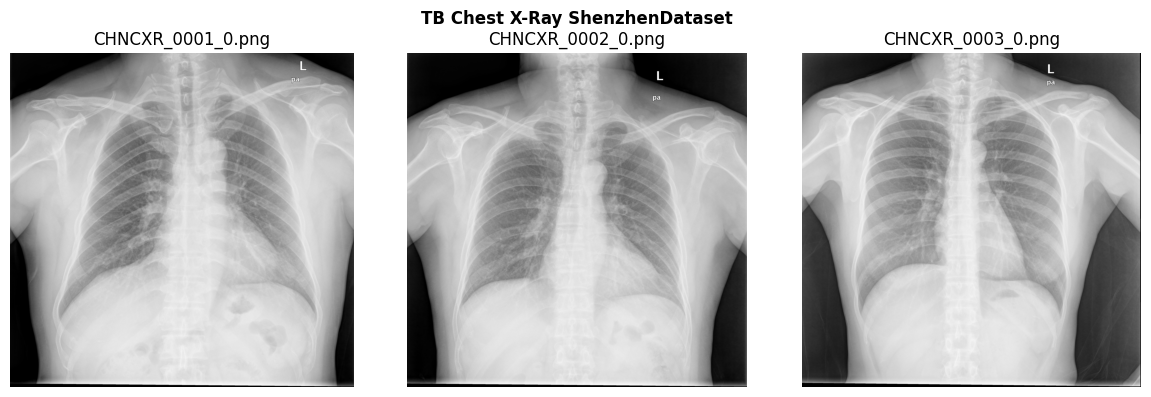

In [23]:
# img_path = r"C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1"

data_files = []
for root, dirs, files in os.walk(img_path):
    for file in files:
        if file.endswith(('.png')):
            data_files.append(os.path.join(root, file))

data_files = sorted(data_files)
# print ("Banyak gambar pada dataset : ",len(data_files))

#Ambil 3 file paling awal
image_files = data_files[:3]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(image_files)):
    img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(os.path.basename(data_files[i]))
    axes[i].axis('off')

plt.suptitle('TB Chest X-Ray ShenzhenDataset', fontweight='bold')
plt.tight_layout()
plt.show()

## Preprocessing

In [24]:
def preprocess_image(img_path, show_steps=True):
    """
    Complete preprocessing pipeline:
    1. Load grayscale image
    2. Resize to standard size
    3. Apply Gaussian blur
    4. Apply CLAHE for contrast enhancement
    """
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to standard size (512x512)
    img = cv2.resize(img, (512, 512))

    # Gaussian filtering to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    if show_steps:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Step 1: Original Image (Resized)', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(blurred, cmap='gray')
        axes[1].set_title('Step 2: Gaussian Blur (5x5)', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(enhanced, cmap='gray')
        axes[2].set_title('Step 3: CLAHE Enhancement', fontsize=12, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle('PREPROCESSING STEPS', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    return img, blurred, enhanced

## Segmentation

In [25]:
def segment_lungs(enhanced_img, show_steps=True):
    """
    Segment lung regions from chest X-ray:
    1. Otsu thresholding (INVERTED to get dark regions = lungs)
    2. Morphological operations to clean up
    3. Find largest connected components (lungs)
    4. Create lung mask
    """
    # Otsu threshold - INVERSE to get lungs (dark areas)
    _, binary = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological opening to remove small noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=2)

    # Morphological closing to fill gaps
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=3)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create mask and select two largest regions (left and right lungs)
    mask = np.zeros_like(enhanced_img)

    if len(contours) > 0:
        # Sort contours by area
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        # Take top 2 largest contours (lungs) or top 1 if only one is found
        num_lungs = min(2, len(contours))
        for i in range(num_lungs):
            # Filter by area - must be significant
            if cv2.contourArea(contours[i]) > 1000:
                cv2.drawContours(mask, [contours[i]], -1, 255, -1)

    # Additional morphological closing on final mask
    kernel_final = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_final, iterations=2)

    if show_steps:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        axes[0, 0].imshow(enhanced_img, cmap='gray')
        axes[0, 0].set_title('Step 4: Input (Enhanced Image)', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(binary, cmap='gray')
        axes[0, 1].set_title('Step 5: Otsu Threshold (Inverted)', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(opened, cmap='gray')
        axes[0, 2].set_title('Step 6: Morphological Opening', fontsize=12, fontweight='bold')
        axes[0, 2].axis('off')

        axes[1, 0].imshow(closed, cmap='gray')
        axes[1, 0].set_title('Step 7: Morphological Closing', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(mask, cmap='gray')
        axes[1, 1].set_title('Step 8: Final Lung Mask', fontsize=12, fontweight='bold')
        axes[1, 1].axis('off')

        # Apply mask to show segmented lungs
        result = cv2.bitwise_and(enhanced_img, enhanced_img, mask=mask)
        axes[1, 2].imshow(result, cmap='gray')
        axes[1, 2].set_title('Step 9: Segmented Lungs', fontsize=12, fontweight='bold')
        axes[1, 2].axis('off')

        plt.suptitle('SEGMENTATION STEPS', fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

    return mask, binary, closed

## Feature Extraction

In [26]:
def extract_shape_features(mask):
    """Extract geometrical features from lung region."""
    # Label connected components
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    if len(regions) == 0:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'extent': 0, 'solidity': 0, 'major_axis': 0, 'minor_axis': 0
        }

    # Combine all regions (both lungs)
    total_area = sum([r.area for r in regions])
    total_perimeter = sum([r.perimeter for r in regions])
    avg_eccentricity = np.mean([r.eccentricity for r in regions])
    avg_extent = np.mean([r.extent for r in regions])
    avg_solidity = np.mean([r.solidity for r in regions])
    avg_major = np.mean([r.major_axis_length for r in regions])
    avg_minor = np.mean([r.minor_axis_length for r in regions])

    return {
        'area': total_area,
        'perimeter': total_perimeter,
        'eccentricity': avg_eccentricity,
        'extent': avg_extent,
        'solidity': avg_solidity,
        'major_axis': avg_major,
        'minor_axis': avg_minor
    }

In [27]:
def extract_first_order_stats(image, mask):
    """Extract first-order statistical features from masked region."""
    # Apply mask to get only lung pixels
    masked_pixels = image[mask > 0]

    if len(masked_pixels) == 0:
        return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness',
                               'kurtosis', 'entropy', 'smoothness', 'uniformity']}

    mean = np.mean(masked_pixels)
    variance = np.var(masked_pixels)
    std_dev = np.std(masked_pixels)
    skewness = stats.skew(masked_pixels)
    kurtosis = stats.kurtosis(masked_pixels)

    # Histogram-based features
    hist, _ = np.histogram(masked_pixels, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]  # Remove zero bins
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    smoothness = 1 - (1 / (1 + variance))
    uniformity = np.sum(hist ** 2)

    return {
        'mean': mean,
        'variance': variance,
        'std_dev': std_dev,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'smoothness': smoothness,
        'uniformity': uniformity
    }

In [28]:
def extract_glcm_features(image, mask):
    """Extract GLCM texture features."""
    # Apply mask
    masked_img = image.copy()
    masked_img[mask == 0] = 0

    # Normalize to 0-255
    img_8bit = cv2.normalize(masked_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Compute GLCM in 4 directions
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(img_8bit, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)

    # Extract properties
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    asm = graycoprops(glcm, 'ASM').mean()

    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'energy': energy,
        'correlation': correlation,
        'ASM': asm
    }

## Extract ALL Features

In [29]:
def extract_all_features(img_path, show_steps=True):
    """Extract all features from a single image."""
    print(f"\n{'='*60}")
    print(f"Processing: {os.path.basename(img_path)}")
    print(f"{'='*60}")

    # Preprocessing
    print("\n[1/3] Preprocessing...")
    original, blurred, enhanced = preprocess_image(img_path, show_steps=show_steps)

    # Segmentation
    print("[2/3] Segmenting lungs...")
    lung_mask, binary, closed = segment_lungs(enhanced, show_steps=show_steps)

    # Feature extraction
    print("[3/3] Extracting features...")
    shape_features = extract_shape_features(lung_mask)
    stats_features = extract_first_order_stats(enhanced, lung_mask)
    glcm_features = extract_glcm_features(enhanced, lung_mask)

    # Show feature extraction results
    if show_steps:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Visualize shape features
        result = cv2.bitwise_and(enhanced, enhanced, mask=lung_mask)
        axes[0].imshow(result, cmap='gray')
        axes[0].set_title('Step 10: Segmented Lung Region\n(for Shape Features)',
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Show histogram for statistical features
        masked_pixels = enhanced[lung_mask > 0]
        axes[1].hist(masked_pixels, bins=50, color='blue', alpha=0.7)
        axes[1].set_title('Step 11: Pixel Intensity Histogram\n(for Statistical Features)',
                         fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Pixel Intensity')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True, alpha=0.3)

        # Show texture visualization
        axes[2].imshow(result, cmap='gray')
        axes[2].set_title('Step 12: Texture Region\n(for GLCM Features)',
                         fontsize=12, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle('FEATURE EXTRACTION STEPS', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # Print extracted features
        print("\n" + "="*60)
        print("EXTRACTED FEATURES:")
        print("="*60)

        print("\n1. Shape Features:")
        for key, value in shape_features.items():
            print(f"   {key:15s}: {value:.4f}")

        print("\n2. Statistical Features:")
        for key, value in stats_features.items():
            print(f"   {key:15s}: {value:.4f}")

        print("\n3. GLCM Texture Features:")
        for key, value in glcm_features.items():
            print(f"   {key:15s}: {value:.4f}")

        print("="*60)

    # Combine all features
    all_features = {**shape_features, **stats_features, **glcm_features}

    return all_features, lung_mask, enhanced

## Pipeline

In [30]:
def process_dataset(image_paths, labels, show_progress=True):
    """Process entire dataset and extract features."""
    features_list = []
    valid_labels = []

    total = len(image_paths)
    print(f"\n{'='*60}")
    print(f"PROCESSING DATASET: {total} images")
    print(f"{'='*60}\n")

    for idx, img_path in enumerate(image_paths):
        try:
            if show_progress:
                print(f"[{idx+1}/{total}] Processing: {os.path.basename(img_path)}")

            features, _, _ = extract_all_features(img_path, show_steps=False)
            features_list.append(features)
            valid_labels.append(labels[idx])

        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            continue

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['label'] = valid_labels

    print(f"\n✅ Successfully processed {len(features_list)}/{total} images")
    print(f"{'='*60}\n")

    return features_df

## MODEL Training

### NB MODEL

In [31]:
def train_naive_bayes(X_train, y_train, X_test, y_test):
    """Train and evaluate Naive Bayes classifier."""
    print("\n" + "="*60)
    print("NAIVE BAYES CLASSIFIER")
    print("="*60)

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    y_pred = nb_model.predict(X_test)

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'TB']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("="*60)

    return nb_model

### SVM MODEL

In [32]:
def train_svm(X_train, y_train, X_test, y_test):
    """Train and evaluate SVM classifier."""
    print("\n" + "="*60)
    print("SVM CLASSIFIER")
    print("="*60)

    # SVM with RBF kernel
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'TB']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("="*60)

    return svm_model

## Visualization

In [33]:
def visualize_complete_pipeline(img_path):
    """
    Visualize the COMPLETE pipeline with ALL steps in one figure.
    Perfect for presentations and reports!
    """
    print(f"\n{'='*60}")
    print(f"COMPLETE PIPELINE VISUALIZATION")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"{'='*60}\n")

    # Process image
    original, blurred, enhanced = preprocess_image(img_path, show_steps=False)
    lung_mask, binary, closed = segment_lungs(enhanced, show_steps=False)

    # Apply mask to original
    result = cv2.bitwise_and(enhanced, enhanced, mask=lung_mask)

    # Create overlay (green mask on original)
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
    overlay[lung_mask > 0] = [0, 255, 0]

    # Create figure with all steps
    fig = plt.figure(figsize=(18, 12))

    # Row 1: Preprocessing
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(original, cmap='gray')
    ax1.set_title('1. Original Image', fontsize=11, fontweight='bold')
    ax1.axis('off')

    ax2 = plt.subplot(3, 4, 2)
    ax2.imshow(blurred, cmap='gray')
    ax2.set_title('2. Gaussian Blur', fontsize=11, fontweight='bold')
    ax2.axis('off')

    ax3 = plt.subplot(3, 4, 3)
    ax3.imshow(enhanced, cmap='gray')
    ax3.set_title('3. CLAHE Enhanced', fontsize=11, fontweight='bold')
    ax3.axis('off')

    ax4 = plt.subplot(3, 4, 4)
    ax4.imshow(binary, cmap='gray')
    ax4.set_title('4. Otsu Threshold', fontsize=11, fontweight='bold')
    ax4.axis('off')

    # Row 2: Segmentation
    ax5 = plt.subplot(3, 4, 5)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=2)
    ax5.imshow(opened, cmap='gray')
    ax5.set_title('5. Opening', fontsize=11, fontweight='bold')
    ax5.axis('off')

    ax6 = plt.subplot(3, 4, 6)
    ax6.imshow(closed, cmap='gray')
    ax6.set_title('6. Closing', fontsize=11, fontweight='bold')
    ax6.axis('off')

    ax7 = plt.subplot(3, 4, 7)
    ax7.imshow(lung_mask, cmap='gray')
    ax7.set_title('7. Lung Mask', fontsize=11, fontweight='bold')
    ax7.axis('off')

    ax8 = plt.subplot(3, 4, 8)
    ax8.imshow(result, cmap='gray')
    ax8.set_title('8. Segmented Lungs', fontsize=11, fontweight='bold')
    ax8.axis('off')

    # Row 3: Results and Features
    ax9 = plt.subplot(3, 4, 9)
    ax9.imshow(overlay)
    ax9.set_title('9. Overlay Result', fontsize=11, fontweight='bold')
    ax9.axis('off')

    # Histogram
    ax10 = plt.subplot(3, 4, 10)
    masked_pixels = enhanced[lung_mask > 0]
    ax10.hist(masked_pixels, bins=50, color='blue', alpha=0.7)
    ax10.set_title('10. Intensity Histogram', fontsize=11, fontweight='bold')
    ax10.set_xlabel('Intensity')
    ax10.set_ylabel('Frequency')
    ax10.grid(True, alpha=0.3)

    # Extract features for display
    shape_features = extract_shape_features(lung_mask)
    stats_features = extract_first_order_stats(enhanced, lung_mask)

    # Display key features as text
    ax11 = plt.subplot(3, 4, 11)
    ax11.axis('off')
    feature_text = "Key Features:\n\n"
    feature_text += f"Area: {shape_features['area']:.0f}\n"
    feature_text += f"Perimeter: {shape_features['perimeter']:.2f}\n"
    feature_text += f"Eccentricity: {shape_features['eccentricity']:.4f}\n\n"
    feature_text += f"Mean: {stats_features['mean']:.2f}\n"
    feature_text += f"Std Dev: {stats_features['std_dev']:.2f}\n"
    feature_text += f"Entropy: {stats_features['entropy']:.4f}\n"
    ax11.text(0.1, 0.5, feature_text, fontsize=10, verticalalignment='center',
              family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax11.set_title('11. Extracted Features', fontsize=11, fontweight='bold')

    # Final result
    ax12 = plt.subplot(3, 4, 12)
    ax12.imshow(result, cmap='gray')
    ax12.set_title('12. Final Result', fontsize=11, fontweight='bold')
    ax12.axis('off')

    plt.suptitle(f'COMPLETE TB DETECTION PIPELINE\n{os.path.basename(img_path)}',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()

    # Save figure
    output_filename = f'complete_pipeline_{os.path.basename(img_path)}'
    plt.savefig(output_filename, dpi=150, bbox_inches='tight')
    print(f"✅ Visualization saved as: {output_filename}")

    plt.show()

## Testing Image

In [34]:
def demo_single_image(img_path):
    """
    Demo: Process a single image and show ALL steps.
    Perfect for testing and presentation!
    """
    print("\n" + "="*60)
    print("DEMO: SINGLE IMAGE PROCESSING WITH ALL STEPS")
    print("="*60)

    # Method 1: Show steps separately
    print("\n--- Method 1: Detailed Step-by-Step ---")
    features, lung_mask, enhanced = extract_all_features(img_path, show_steps=True)

    # Method 2: Show complete pipeline in one figure
    print("\n--- Method 2: Complete Pipeline View ---")
    visualize_complete_pipeline(img_path)

    return features, lung_mask, enhanced


def demo_multiple_images(image_files, num_images=3):
    """
    Demo: Process multiple images and show comparisons.
    """
    print("\n" + "="*60)
    print(f"DEMO: PROCESSING {num_images} IMAGES")
    print("="*60)

    for i in range(min(num_images, len(image_files))):
        print(f"\n\n{'#'*60}")
        print(f"IMAGE {i+1}/{num_images}")
        print(f"{'#'*60}")
        visualize_complete_pipeline(image_files[i])

## Main Function 


    ╔══════════════════════════════════════════════════════════╗
    ║         TB DETECTION PIPELINE - STEP-BY-STEP             ║
    ║              Digital Image Processing Project            ║
    ╚══════════════════════════════════════════════════════════╝
    
Found 662 images in dataset

🔍 Showing Complete Pipeline for 3 images

IMAGE 1/3: CHNCXR_0001_0.png

COMPLETE PIPELINE VISUALIZATION
Image: CHNCXR_0001_0.png

✅ Visualization saved as: complete_pipeline_CHNCXR_0001_0.png
✅ Visualization saved as: complete_pipeline_CHNCXR_0001_0.png


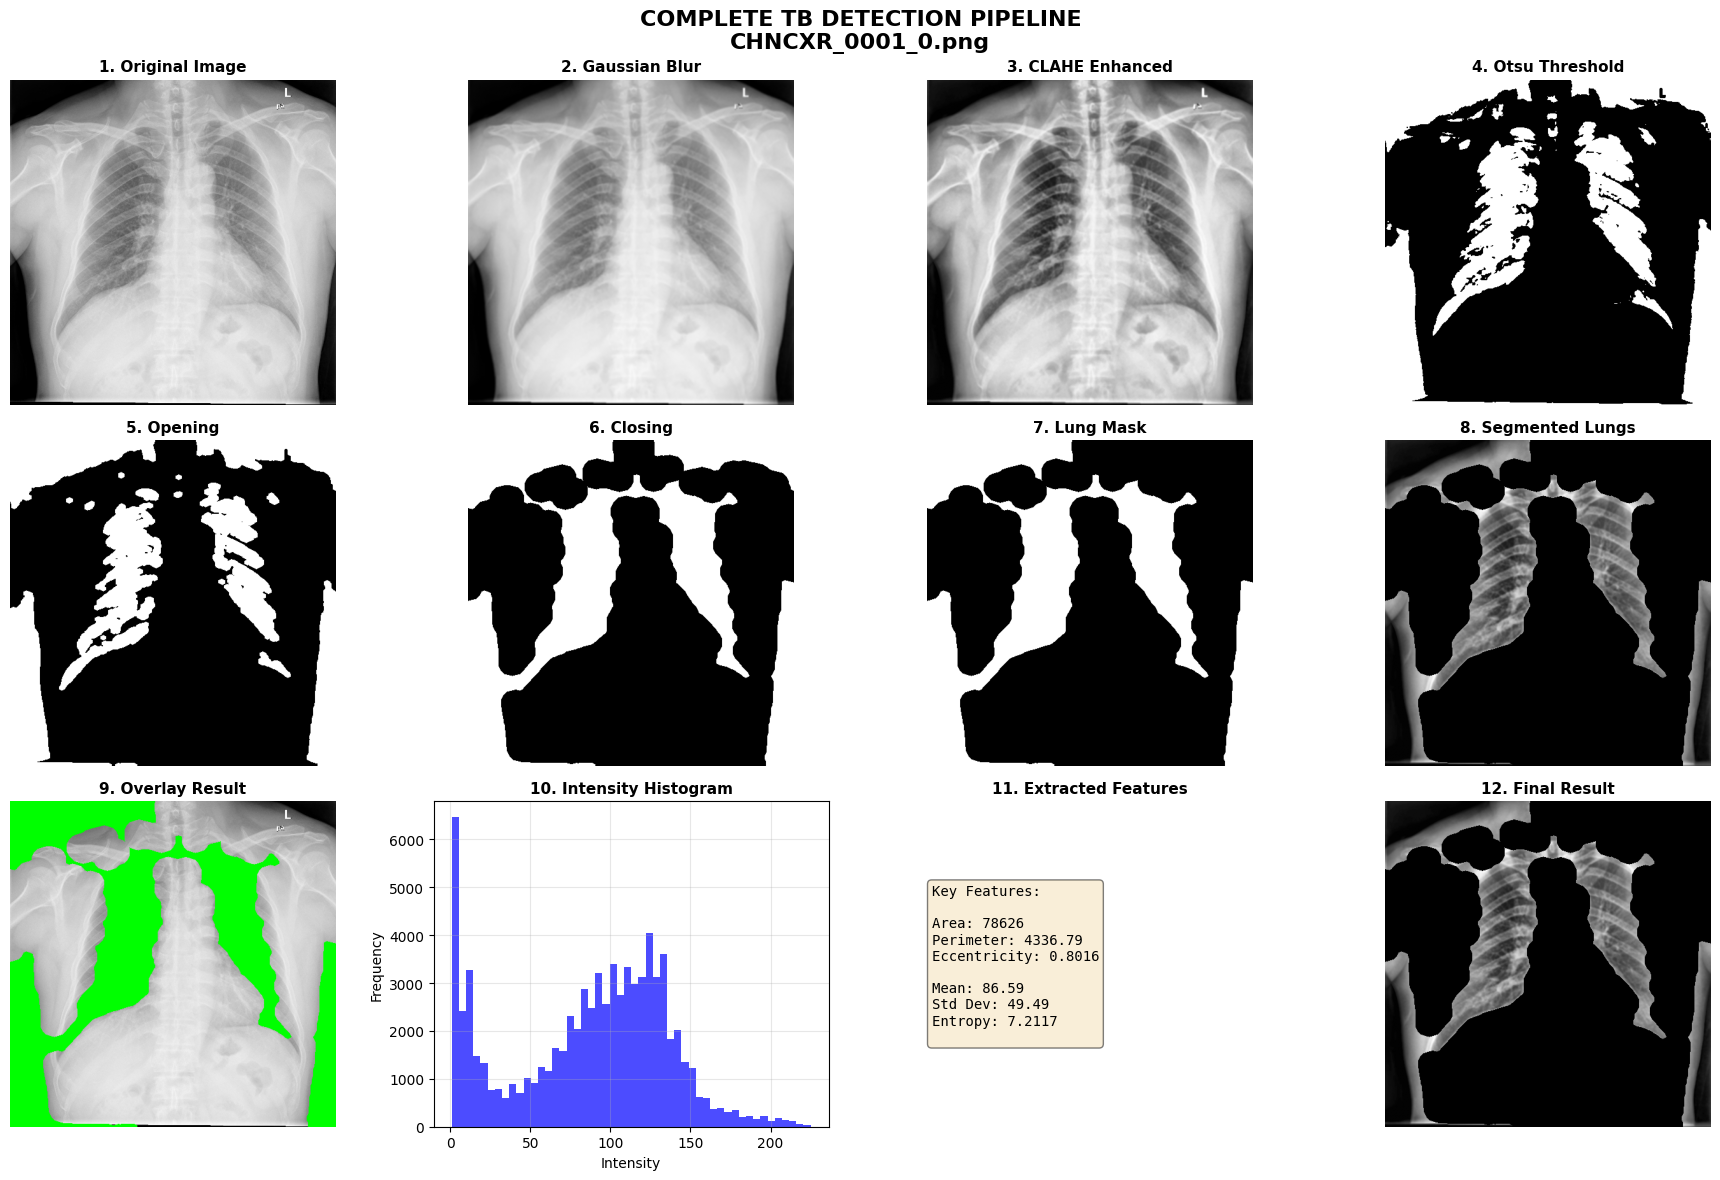


IMAGE 2/3: CHNCXR_0002_0.png

COMPLETE PIPELINE VISUALIZATION
Image: CHNCXR_0002_0.png

✅ Visualization saved as: complete_pipeline_CHNCXR_0002_0.png
✅ Visualization saved as: complete_pipeline_CHNCXR_0002_0.png


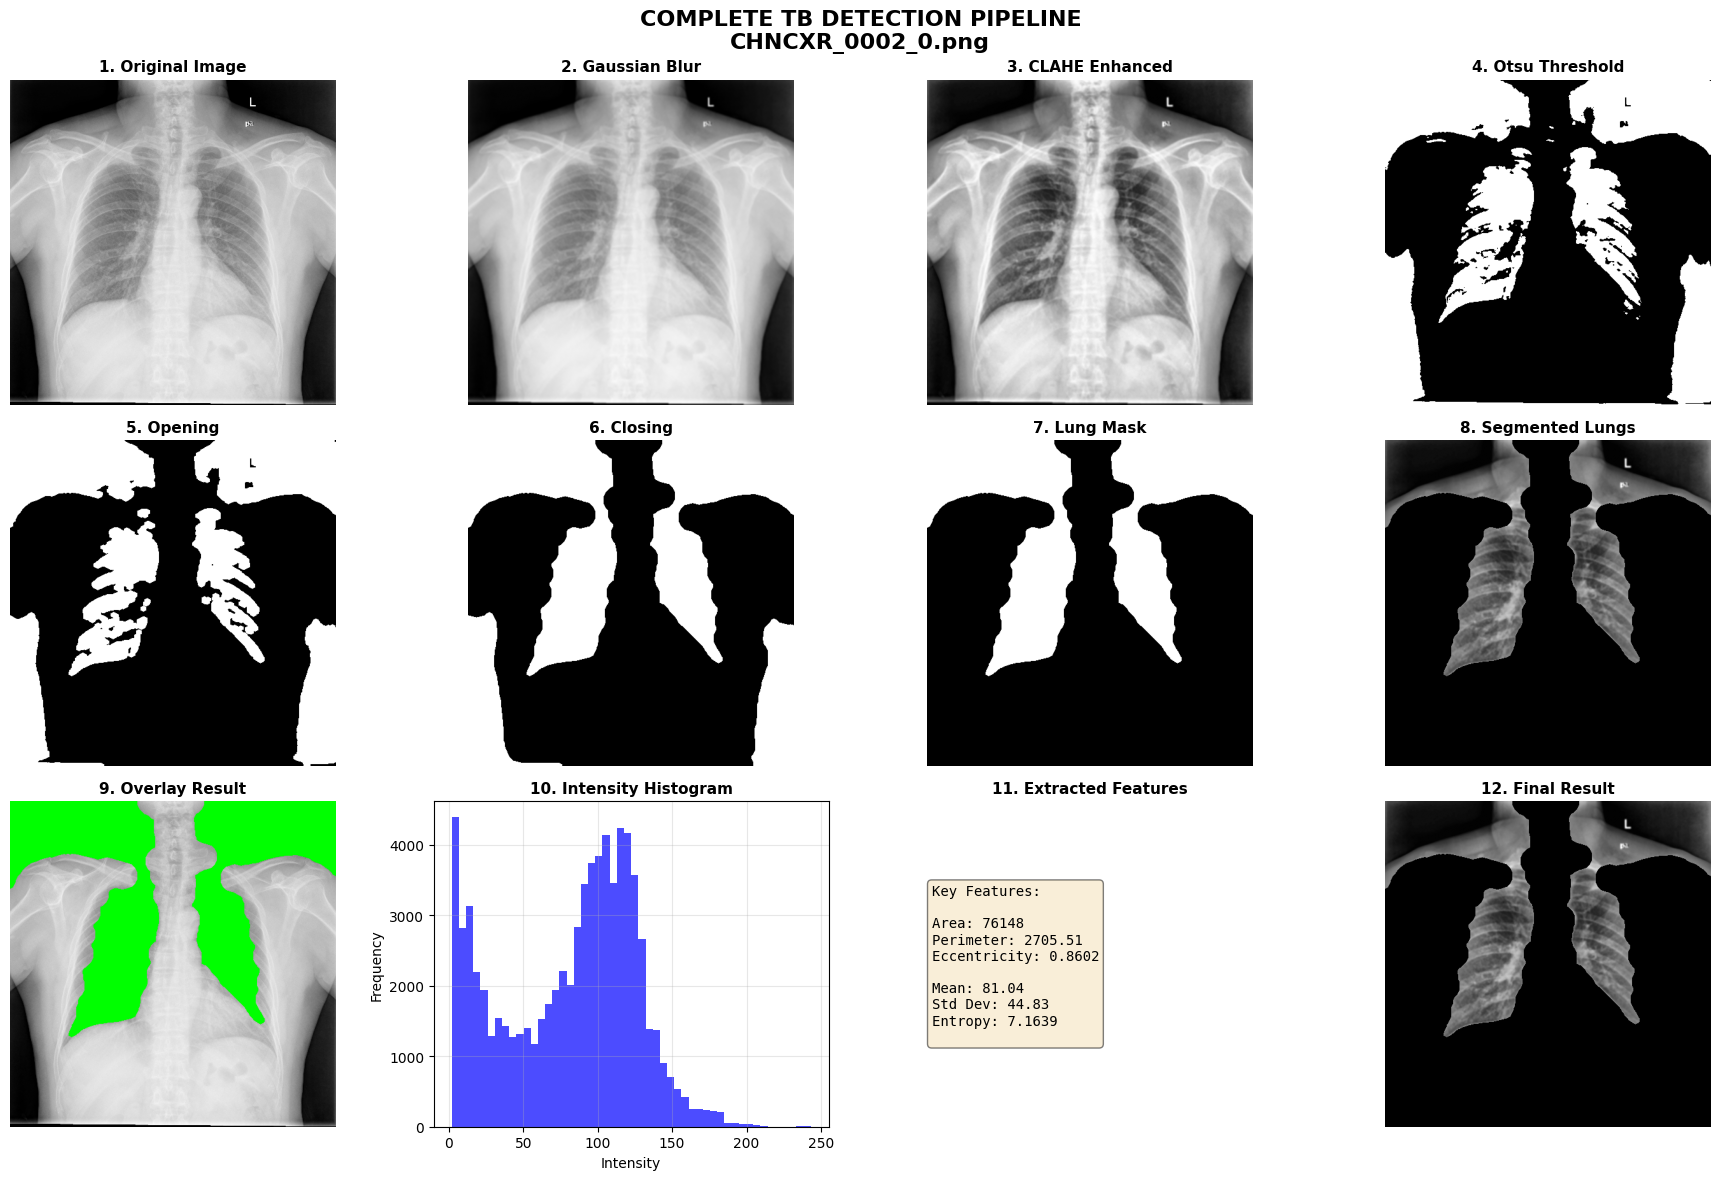


IMAGE 3/3: CHNCXR_0003_0.png

COMPLETE PIPELINE VISUALIZATION
Image: CHNCXR_0003_0.png

✅ Visualization saved as: complete_pipeline_CHNCXR_0003_0.png
✅ Visualization saved as: complete_pipeline_CHNCXR_0003_0.png


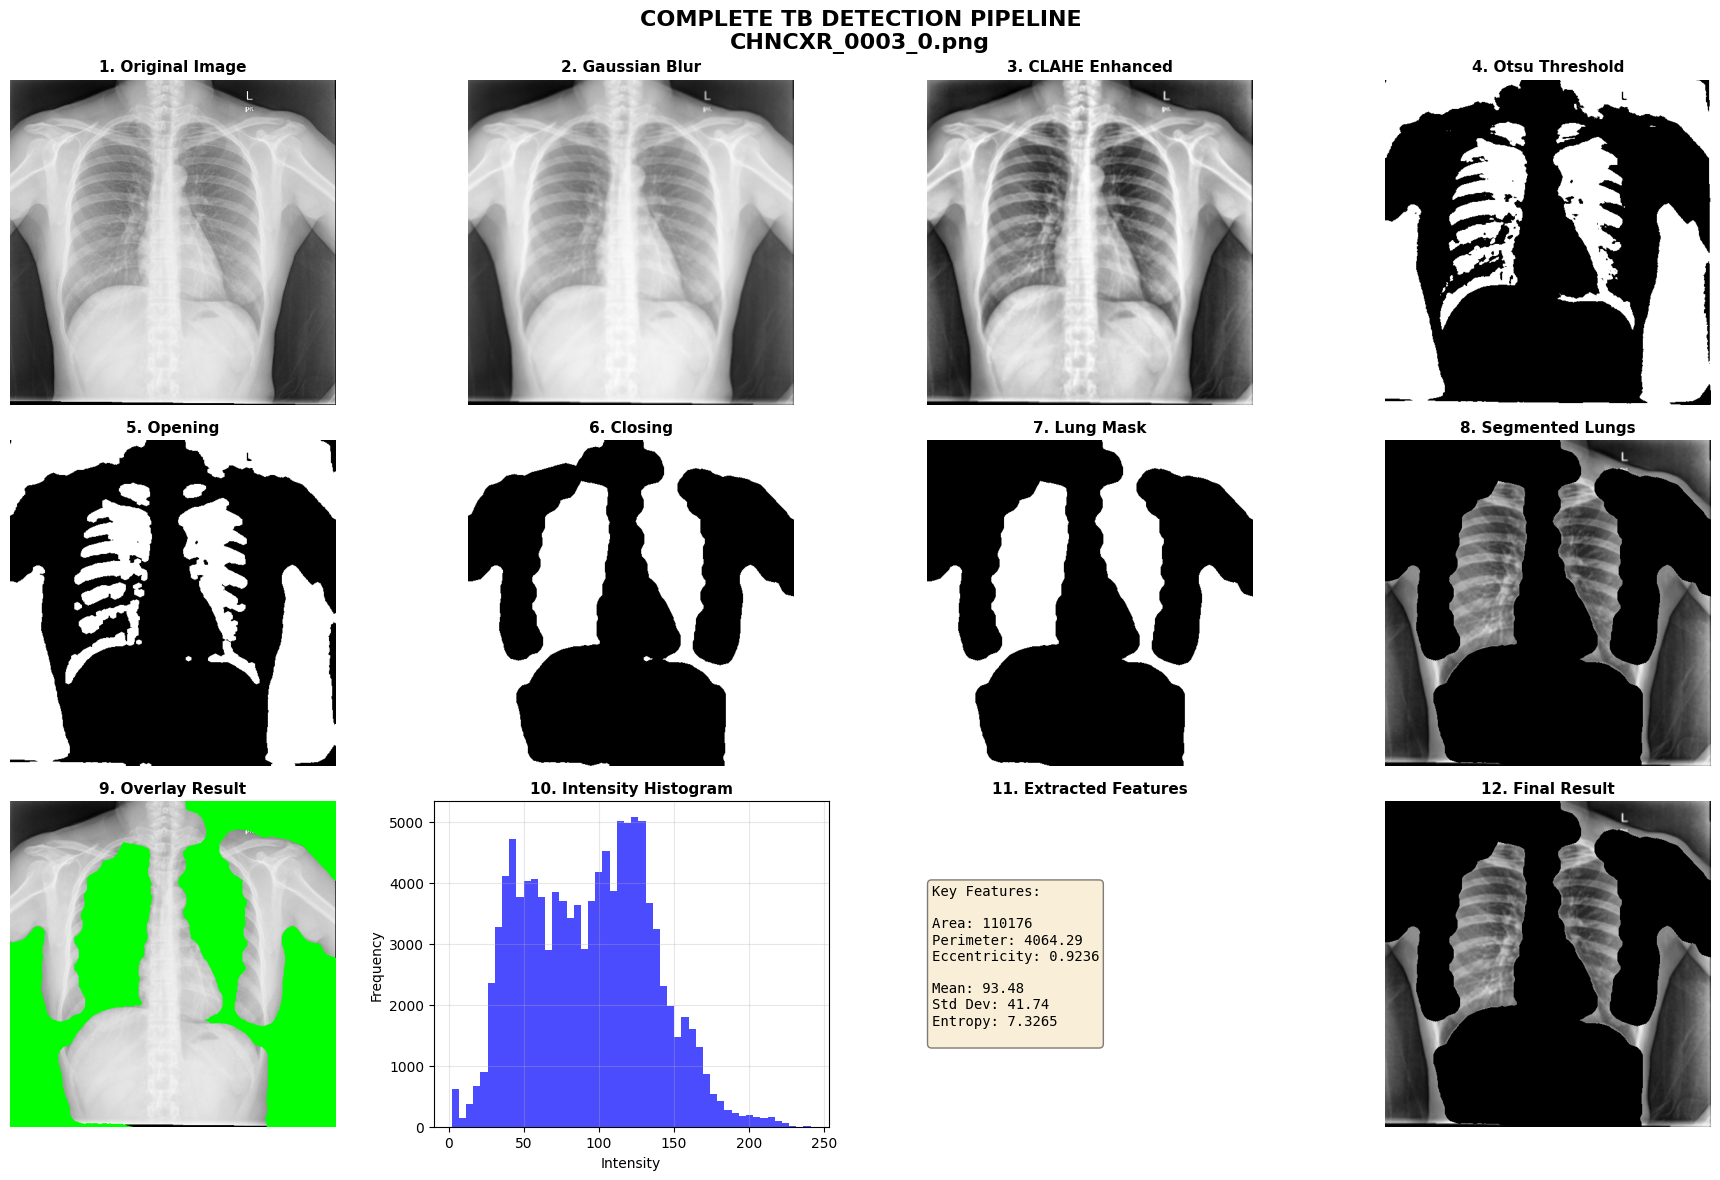


✅ Processing completed!


In [35]:
if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════════════╗
    ║         TB DETECTION PIPELINE - STEP-BY-STEP             ║
    ║              Digital Image Processing Project            ║
    ╚══════════════════════════════════════════════════════════╝
    """)

    # Get all image files
    all_files = []
    for root, dirs, files in os.walk(img_path):
        for file in files:
            if file.endswith('.png'):
                all_files.append(os.path.join(root, file))

    print(f"Found {len(all_files)} images in dataset\n")

    # Show complete pipeline for 3 images
    print("🔍 Showing Complete Pipeline for 3 images")
    for i in range(min(3, len(all_files))):
        print(f"\n{'='*60}")
        print(f"IMAGE {i+1}/3: {os.path.basename(all_files[i])}")
        print(f"{'='*60}")
        visualize_complete_pipeline(all_files[i])

    print("\n✅ Processing completed!")

In [36]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def preprocess_image(img_path, show_steps=False):
    """
    Complete preprocessing pipeline:
    1. Load grayscale image
    2. Resize to standard size
    3. Apply Gaussian blur
    4. Apply CLAHE for contrast enhancement
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None, None

    # Resize to standard size (512x512)
    img = cv2.resize(img, (512, 512))

    # Gaussian filtering to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    return img, blurred, enhanced

# ============================================================================
# SEGMENTATION FUNCTIONS
# ============================================================================

def segment_lungs(enhanced_img, show_steps=False):
    """
    Segment lung regions using improved morphological operations.
    KEY IMPROVEMENT: Uses INVERTED thresholding to get dark lung regions.
    """
    if enhanced_img is None:
        return None, None, None

    # CRITICAL: Inverse Otsu to get lungs (dark areas in X-ray)
    _, binary = cv2.threshold(enhanced_img, 0, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological opening to remove noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=2)

    # Morphological closing to fill gaps
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=3)

    # Find contours and select largest regions (lungs)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create mask
    mask = np.zeros_like(enhanced_img)

    if len(contours) > 0:
        # Sort by area and take top 2 (left and right lung)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        num_lungs = min(2, len(contours))

        for i in range(num_lungs):
            if cv2.contourArea(contours[i]) > 1000:  # Filter small regions
                cv2.drawContours(mask, [contours[i]], -1, 255, -1)

    # Final closing on mask
    kernel_final = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_final, iterations=2)

    return mask, binary, closed

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def extract_shape_features(mask):
    """Extract geometrical features from lung region."""
    if mask is None or np.sum(mask) == 0:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'extent': 0, 'solidity': 0, 'major_axis': 0, 'minor_axis': 0
        }

    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    if len(regions) == 0:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'extent': 0, 'solidity': 0, 'major_axis': 0, 'minor_axis': 0
        }

    # Aggregate features from all regions
    total_area = sum([r.area for r in regions])
    total_perimeter = sum([r.perimeter for r in regions])
    avg_eccentricity = np.mean([r.eccentricity for r in regions])
    avg_extent = np.mean([r.extent for r in regions])
    avg_solidity = np.mean([r.solidity for r in regions])
    avg_major = np.mean([r.major_axis_length for r in regions])
    avg_minor = np.mean([r.minor_axis_length for r in regions])

    return {
        'area': total_area,
        'perimeter': total_perimeter,
        'eccentricity': avg_eccentricity,
        'extent': avg_extent,
        'solidity': avg_solidity,
        'major_axis': avg_major,
        'minor_axis': avg_minor
    }

def extract_first_order_stats(image, mask):
    """Extract first-order statistical features."""
    if image is None or mask is None or np.sum(mask) == 0:
        return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness',
                               'kurtosis', 'entropy', 'smoothness', 'uniformity']}

    masked_pixels = image[mask > 0]

    if len(masked_pixels) == 0:
        return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness',
                               'kurtosis', 'entropy', 'smoothness', 'uniformity']}

    mean = np.mean(masked_pixels)
    variance = np.var(masked_pixels)
    std_dev = np.std(masked_pixels)
    skewness = stats.skew(masked_pixels)
    kurtosis = stats.kurtosis(masked_pixels)

    # Histogram-based features
    hist, _ = np.histogram(masked_pixels, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    smoothness = 1 - (1 / (1 + variance))
    uniformity = np.sum(hist ** 2)

    return {
        'mean': mean,
        'variance': variance,
        'std_dev': std_dev,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'smoothness': smoothness,
        'uniformity': uniformity
    }

def extract_glcm_features(image, mask):
    """Extract GLCM texture features."""
    if image is None or mask is None or np.sum(mask) == 0:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

    masked_img = image.copy()
    masked_img[mask == 0] = 0

    # Check if there's meaningful data
    if np.all(masked_img == 0) or len(np.unique(masked_img)) < 2:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

    # Normalize to 8-bit
    img_8bit = cv2.normalize(masked_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Compute GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    try:
        glcm = graycomatrix(img_8bit, distances=distances, angles=angles,
                           levels=256, symmetric=True, normed=True)

        # Extract properties
        contrast = graycoprops(glcm, 'contrast').mean()
        dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()
        energy = graycoprops(glcm, 'energy').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
        asm = graycoprops(glcm, 'ASM').mean()

        return {
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'ASM': asm
        }
    except:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

# ============================================================================
# PIPELINE FUNCTIONS
# ============================================================================

def extract_all_features(img_path, show_steps=False):
    """Extract all features from a single image."""
    # Preprocessing
    original, blurred, enhanced = preprocess_image(img_path, show_steps=show_steps)

    if enhanced is None:
        return None

    # Segmentation
    lung_mask, binary, closed = segment_lungs(enhanced, show_steps=show_steps)

    if lung_mask is None:
        return None

    # Feature extraction
    shape_features = extract_shape_features(lung_mask)
    stats_features = extract_first_order_stats(enhanced, lung_mask)
    glcm_features = extract_glcm_features(enhanced, lung_mask)

    # Combine all features
    all_features = {**shape_features, **stats_features, **glcm_features}

    return all_features

def extract_dataset(df, limit=None, show_progress=True):
    """Process entire dataset and extract features for training."""
    features_list = []
    labels = []

    total = len(df) if limit is None else min(limit, len(df))

    print(f"\n{'='*60}")
    print(f"EXTRACTING FEATURES FROM DATASET")
    print(f"Total images to process: {total}")
    print(f"{'='*60}\n")

    for idx, row in df.iterrows():
        if limit and idx >= limit:
            break

        if show_progress and idx % 50 == 0:
            print(f"Processing {idx+1}/{total}...")

        try:
            features = extract_all_features(row['path'], show_steps=False)
            if features is not None:
                features_list.append(features)
                labels.append(row['label'])
        except Exception as e:
            print(f"❌ Error processing {row['path']}: {e}")
            continue

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['label'] = labels

    print(f"\n✅ Successfully processed {len(features_list)}/{total} images")
    print(f"Features extracted: {len(features_df.columns) - 1}")
    print(f"{'='*60}\n")

    return features_df

# ============================================================================
# HIERARCHICAL CLASSIFIER
# ============================================================================

class klasifikasiHierarkis:
    """
    Hierarchical classification:
    Stage 1: Shape features (initial screening)
    Stage 2: All features (refinement for uncertain cases)
    """

    def __init__(self, model_type='svm'):
        self.model_type = model_type
        self.stage1_model = None
        self.stage2_model = None
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        self.shape_cols = None
        self.all_cols = None
        self.is_fitted = False

    def fit(self, X, y):
        self.all_cols = X.columns.tolist()

        # Identify shape features
        self.shape_cols = [col for col in X.columns if any(
            keyword in col for keyword in ['area', 'perimeter', 'eccentricity',
                                          'extent', 'solidity', 'major', 'minor']
        )]

        X_shape = X[self.shape_cols]
        X_all = X

        # Scale features
        X_shape_scaled = self.scaler1.fit_transform(X_shape)
        X_all_scaled = self.scaler2.fit_transform(X_all)

        # Initialize models
        if self.model_type == 'svm':
            self.stage1_model = SVC(kernel='rbf', C=10, gamma='scale',
                                   probability=True, random_state=42,
                                   class_weight='balanced')
            self.stage2_model = SVC(kernel='rbf', C=10, gamma='scale',
                                   probability=True, random_state=42,
                                   class_weight='balanced')
        else:  # Naive Bayes
            self.stage1_model = GaussianNB()
            self.stage2_model = GaussianNB()

        # Train models
        print(f"\n🔧 Training {self.model_type.upper()} Hierarchical Model...")
        self.stage1_model.fit(X_shape_scaled, y)
        self.stage2_model.fit(X_all_scaled, y)

        self.is_fitted = True

        print(f"✅ Model trained successfully:")
        print(f"  Stage 1: {len(self.shape_cols)} shape features")
        print(f"  Stage 2: {len(self.all_cols)} total features")

        return self

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")

        X = X[self.all_cols]
        X_shape = X[self.shape_cols]

        X_shape_scaled = self.scaler1.transform(X_shape)
        X_all_scaled = self.scaler2.transform(X)

        # Stage 1: Quick screening with shape features
        stage1_pred = self.stage1_model.predict(X_shape_scaled)

        # Stage 2: Refinement with all features
        final_pred = stage1_pred.copy()
        for i in range(len(stage1_pred)):
            if stage1_pred[i] == 0:  # If predicted normal, double check
                stage2_pred = self.stage2_model.predict(X_all_scaled[i:i+1])
                final_pred[i] = stage2_pred[0]

        return final_pred

    def predict_proba(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")

        X = X[self.all_cols]
        X_all_scaled = self.scaler2.transform(X)
        return self.stage2_model.predict_proba(X_all_scaled)

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance with detailed metrics and visualization."""
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n📊 Accuracy: {accuracy:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'TB']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n🎯 Additional Metrics:")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"{'='*60}")

    return accuracy, y_pred, model

# ============================================================================
# MODEL PERSISTENCE
# ============================================================================

def save_models(svm_model, nb_model, base_path='.'):
    """Save trained models to disk."""
    svm_path = os.path.join(base_path, 'svm_model.pkl')
    nb_path = os.path.join(base_path, 'nb_model.pkl')
    
    with open(svm_path, 'wb') as f:
        pickle.dump(svm_model, f)
    
    with open(nb_path, 'wb') as f:
        pickle.dump(nb_model, f)
    
    print(f"\n💾 Models saved successfully:")
    print(f"  SVM: {svm_path}")
    print(f"  Naive Bayes: {nb_path}")

def load_models(base_path='.'):
    """Load trained models from disk."""
    svm_path = os.path.join(base_path, 'svm_model.pkl')
    nb_path = os.path.join(base_path, 'nb_model.pkl')
    
    try:
        with open(svm_path, 'rb') as f:
            svm_model = pickle.load(f)
        
        with open(nb_path, 'rb') as f:
            nb_model = pickle.load(f)
        
        print(f"✅ Models loaded successfully")
        return svm_model, nb_model
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None, None

TB DETECTION - TRAINING PIPELINE

📦 Using FULL dataset for training

📂 Dataset location: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1

🔍 Scanning dataset directory...
✅ Found 662 images

📊 Original Dataset Distribution:
  Normal (0): 326 images
  TB (1): 336 images

EXTRACTING FEATURES FROM DATASET
Total images to process: 662

Processing 1/662...
Processing 51/662...
Processing 51/662...
Processing 101/662...
Processing 101/662...
Processing 151/662...
Processing 151/662...
Processing 201/662...
Processing 201/662...
Processing 251/662...
Processing 251/662...
Processing 301/662...
Processing 301/662...
Processing 351/662...
Processing 351/662...
Processing 401/662...
Processing 401/662...
Processing 451/662...
Processing 451/662...
Processing 501/662...
Processing 501/662...
Processing 551/662...
Processing 551/662...
Processing 601/662...
Processing 601/662...
Processing 651/662...
Processing 651/662...

✅ Successfully processed 662/6

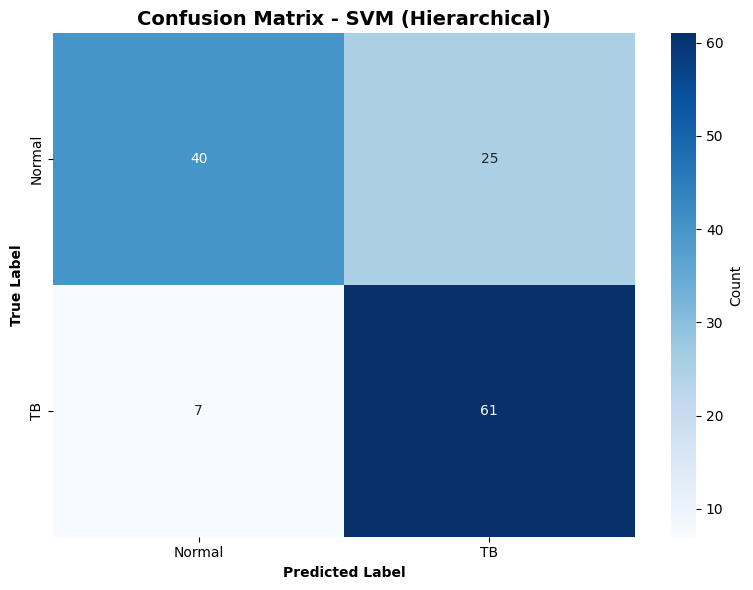


🎯 Additional Metrics:
  Sensitivity (Recall): 0.8971
  Specificity: 0.6154

EVALUATING: Naive Bayes (Hierarchical)

🔧 Training NB Hierarchical Model...
✅ Model trained successfully:
  Stage 1: 7 shape features
  Stage 2: 21 total features

📊 Accuracy: 0.6316

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.51      0.57        65
          TB       0.61      0.75      0.68        68

    accuracy                           0.63       133
   macro avg       0.64      0.63      0.62       133
weighted avg       0.64      0.63      0.63       133



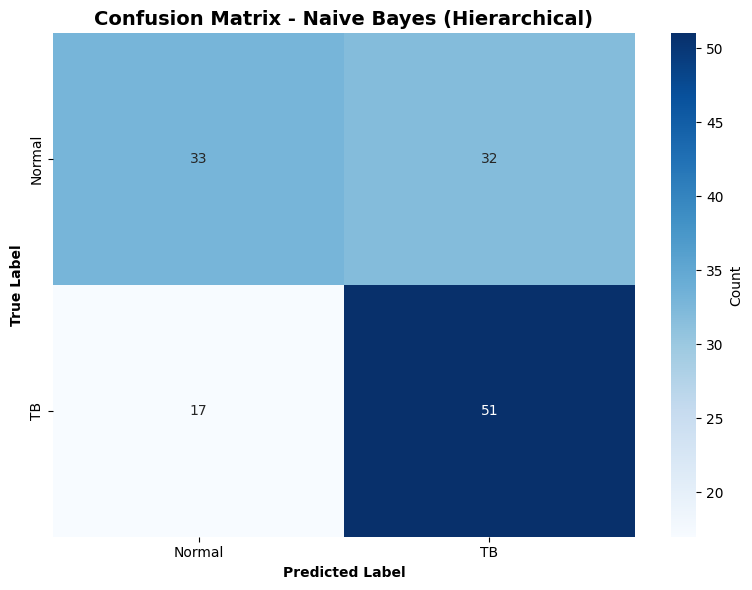


🎯 Additional Metrics:
  Sensitivity (Recall): 0.7500
  Specificity: 0.5077

MODEL COMPARISON


                     Model  Accuracy
        SVM (Hierarchical)  0.759398
Naive Bayes (Hierarchical)  0.631579


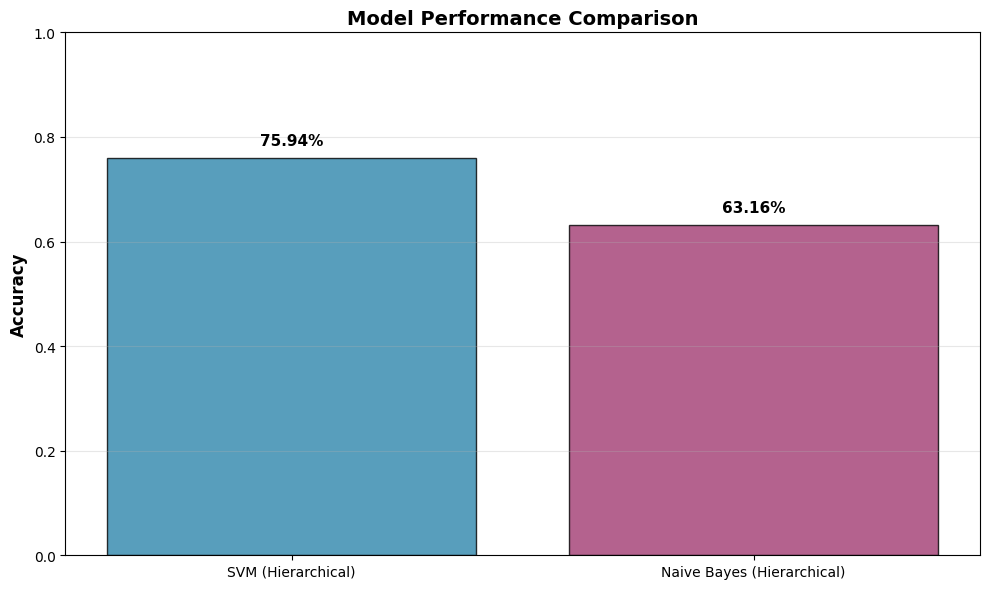


💾 Models saved successfully:
  SVM: .\svm_model.pkl
  Naive Bayes: .\nb_model.pkl

✅ TRAINING COMPLETE!

🏆 Best Model: SVM
   Accuracy: 75.94%


In [37]:
# ============================================================================
# MAIN TRAINING PIPELINE
# ============================================================================

def main():
    """
    Main training function - trains both SVM and Naive Bayes hierarchical models
    """
    print("="*60)
    print("TB DETECTION - TRAINING PIPELINE")
    print("="*60)
    
    # Get configuration from earlier cell
    limit = CONFIG.get("limit_extract")
    
    if limit is None:
        print("\n📦 Using FULL dataset for training")
    else:
        print(f"\n📦 Using LIMITED dataset: {limit} images")
    
    # Use the path variable from the dataset download cell
    try:
        dataset_path = img_path 
        print(f"\n📂 Dataset location: {dataset_path}")
    except NameError:
        # Fallback if 'path' variable doesn't exist
        print("⚠️ Warning: 'path' variable not found. Make sure to run the dataset download cell first!")
        print("   Looking for dataset in default location...")
    
    # Create data list with labels
    print("\n🔍 Scanning dataset directory...")
    data = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png'):
                filepath = os.path.join(root, file)
                # Label based on filename convention: _0.png = Normal, _1.png = TB
                if '_0.png' in file:
                    label = 0  # Normal
                elif '_1.png' in file:
                    label = 1  # TB
                else:
                    label = None  # Unknown
                
                if label is not None:
                    data.append({'path': filepath, 'label': label})
    
    if len(data) == 0:
        print("❌ No valid images found in dataset!")
        print(f"   Searched in: {dataset_path}")
        print("\n💡 Troubleshooting:")
        print("   1. Make sure you ran the dataset download cell correctly")
        print("   2. Check if the dataset was downloaded successfully")
        print("   3. Verify the filenames end with _0.png (Normal) or _1.png (TB)")
        return None, None, None
    
    print(f"✅ Found {len(data)} images")
    
    # Convert to DataFrame and shuffle
    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n📊 Original Dataset Distribution:")
    print(f"  Normal (0): {(df['label']==0).sum()} images")
    print(f"  TB (1): {(df['label']==1).sum()} images")
    
    # Extract features from dataset
    features_df = extract_dataset(df, limit=limit)
    
    if len(features_df) == 0:
        print("❌ Failed to extract features from dataset!")
        return None, None, None
    
    print(f"\n📊 Processed Dataset Distribution:")
    print(f"  Normal (0): {(features_df['label']==0).sum()} images")
    print(f"  TB (1): {(features_df['label']==1).sum()} images")
    
    # Prepare data for training
    X = features_df.drop('label', axis=1)
    y = features_df['label']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n📂 Dataset Split:")
    print(f"  Training set: {len(X_train)} images")
    print(f"  Testing set: {len(X_test)} images")
    
    # Train and evaluate models
    print("\n" + "="*60)
    print("TRAINING AND EVALUATION")
    print("="*60)
    
    # Train SVM Hierarchical Model
    svm_model = klasifikasiHierarkis(model_type='svm')
    svm_acc, svm_pred, svm_trained = evaluate_model(
        svm_model, X_train, X_test, y_train, y_test,
        "SVM (Hierarchical)"
    )
    
    # Train Naive Bayes Hierarchical Model
    nb_model = klasifikasiHierarkis(model_type='nb')
    nb_acc, nb_pred, nb_trained = evaluate_model(
        nb_model, X_train, X_test, y_train, y_test,
        "Naive Bayes (Hierarchical)"
    )
    
    # Model Comparison
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    
    comparison_df = pd.DataFrame({
        'Model': ['SVM (Hierarchical)', 'Naive Bayes (Hierarchical)'],
        'Accuracy': [svm_acc, nb_acc]
    })
    print("\n")
    print(comparison_df.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
                   color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylim([0, 1])
    plt.grid(axis='y', alpha=0.3)
    
    for i, (bar, v) in enumerate(zip(bars, comparison_df['Accuracy'])):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{v:.2%}', ha='center', va='bottom',
                fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Save both models
    save_models(svm_trained, nb_trained)
    
    print("\n" + "="*60)
    print("✅ TRAINING COMPLETE!")
    print("="*60)
    print(f"\n🏆 Best Model: {'SVM' if svm_acc > nb_acc else 'Naive Bayes'}")
    print(f"   Accuracy: {max(svm_acc, nb_acc):.2%}")
    
    return svm_trained, nb_trained, features_df


# Run training pipeline
if __name__ == "__main__":
    svm_model, nb_model, features_df = main()